# Fraud Detection in Electricity and Gas Consumption

## About the data

The [data](https://zindi.africa/competitions/ai-hack-tunisia-4-predictive-analytics-challenge-1/data)  provided by STEG is composed of two files. The first one is comprised of client data and the second one contains billing history since 2005.

<h4> <b> Files</b></h4>

There are 2 .zip files for download, train.zip, and test.zip and a SampleSubmission.csv.

- <b> train.zip </b>

 - Client_train.csv - Client information in the train population
 - Invoice_train.csv - Clients invoice in the train set

- <b> test.zip</b>

 - Client_test.csv - Client information for the test population
 - Invoice_test.csv - Clients invoice in the test set
 - SampleSubmission.csv - is an example of what your submission file should look like. The order of the rows does not matter, but the names of the IDs must be correct. The column "target" is your prediction.


#### <b> Variable definitions </b>

- <b> Client: </b>

 - Client_id: Unique id for client
 - District: District where the client is
 - Client_catg: Category client belongs to
 - Region: Area where the client is
 - Creation_date: Date client joined
 - Target: fraud:1 , not fraud: 0

- <b> Invoice data:</b>

 - Client_id: Unique id for the client
 - Invoice_date: Date of the invoice
 - Tarif_type: Type of tax [more info](https://circuitglobe.com/electricity-tariffs.html)
 - Counter_number:
 - Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
 - Counter_code: 
 - Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
 - Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
 - Consommation_level_1: Consumption_level_1
 - Consommation_level_2: Consumption_level_2
 - Consommation_level_3: Consumption_level_3
 - Consommation_level_4: Consumption_level_4
 - Old_index: Old index
 - New_index: New index
 - Months_number: Month number
 - Counter_type: Type of counter

## A- Data Exploration and Preprocessing

### 1) Importing Dataset and libraries

In [72]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
%cd /content/drive/My Drive/Github/Machine Learning Course Implementations

/content/drive/My Drive/Github/Machine Learning Course Implementations


In [74]:
ls

catboost_info/                          Submission2.csv   Submission50.csv
client_test.csv                         Submission30.csv  Submission51.csv
client_train.csv                        Submission31.csv  Submission52.csv
colabgitWorkflow.ipynb                  Submission32.csv  Submission53.csv
invoice_test.csv                        Submission33.csv  Submission54.csv
invoice_train.csv                       Submission34.csv  Submission55.csv
logs.log                                Submission35.csv  Submission56.csv
Project1:FraudDetectionChallenge.ipynb  Submission36.csv  Submission57.csv
SampleSubmission.csv                    Submission37.csv  Submission58.csv
Submission16.csv                        Submission38.csv  Submission59.csv
Submission17.csv                        Submission39.csv  Submission5.csv
Submission18.csv                        Submission3.csv   Submission60.csv
Submission19.csv                        Submission40.csv  Submission61.csv
Submission20.csv          

In [75]:
# Install Needed libraries
!pip install mlxtend
!pip install mlrose
!pip install catboost

In [140]:
!pip install seaborn --upgrade

In [76]:
#import needed libraries 
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import sklearn.preprocessing
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, MultiTaskLassoCV, LassoLarsCV
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, LeaveOneOut
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, mean_squared_error, r2_score, roc_auc_score, mean_absolute_error

from sklearn.feature_selection import RFE
import lightgbm
from lightgbm import LGBMClassifier
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostClassifier
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
from mlxtend.classifier import StackingCVClassifier
from catboost import CatBoostClassifier
from datetime import datetime, timedelta


In [77]:
train_client=pd.read_csv('./client_train.csv')
test_client=pd.read_csv('./client_test.csv')
train_invoice=pd.read_csv('./invoice_train.csv')
test_invoice=pd.read_csv('./invoice_test.csv')
sub=pd.read_csv('./SampleSubmission.csv')

### 2) Distinguish Attributes

#### a) Train Client

In [78]:
train_client.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [79]:
train_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [80]:
train_client.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


#### b) Train Invoice

In [81]:
train_invoice.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [82]:
train_invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [83]:
train_invoice.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [84]:
train_invoice.reading_remarque.value_counts()

6      2230939
9      1416992
8       828123
7          661
203         15
413         12
207          6
5            1
Name: reading_remarque, dtype: int64

### 3) Missing data and Duplicates

In [85]:
#Train Invoice: Checking Nulls and Duplicates
print('Train invoice: missing values -> {}'.format(train_invoice.isna().sum().sum()))
print('Train invoice: duplicate values -> {}'.format(train_invoice.duplicated().sum()))
# Train Client: Checking Nulls and Duplicates
print('Train client: missing values -> {}'.format(train_client.isna().sum().sum()))
print('Train client: duplicate values -> {}'.format(train_client.duplicated().sum()))

Train invoice: missing values -> 0
Train invoice: duplicate values -> 11
Train client: missing values -> 0
Train client: duplicate values -> 0


In [86]:
# Remove Any duplicates or Missing values
#CODE
train_invoice.drop_duplicates(inplace=True)
#TEST
print('duplicate values -> {}'.format(train_invoice.duplicated().sum()))

duplicate values -> 0


### 4) Data Merging and Transformation

In [87]:
d={"ELEC":0,"GAZ":1}
train_invoice['counter_type']=train_invoice['counter_type'].map(d)

In [88]:
train_client['client_catg'] = train_client['client_catg'].astype('object')
train_client['disrict'] = train_client['disrict'].astype('object')

test_client['client_catg'] = test_client['client_catg'].astype('object')
test_client['disrict'] = test_client['disrict'].astype('object')

In [89]:
train_invoice['counter_type'].value_counts()

0    3079398
1    1397340
Name: counter_type, dtype: int64

In [90]:
for df in [train_invoice,test_invoice]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    df['year'] = df['invoice_date'].dt.year
    df['month'] = df['invoice_date'].dt.month


In [91]:
aggs = {}
aggs['consommation_level_1'] = ['sum','max','min','mean','std']
aggs['consommation_level_2'] = ['sum','max','min','mean','std']
aggs['consommation_level_3'] = ['sum','max','min','mean','std']
aggs['consommation_level_4'] = ['sum','max','min','mean','std']
aggs['month'] = ['mean', 'max', 'min', 'std']
aggs['year'] = ['nunique','max','min','mean']
aggs['months_number'] = ['max','min','mean','sum']
aggs['reading_remarque'] = ['max','min','mean','std','sum']
aggs['counter_coefficient'] = ['max', 'min','mean']
aggs['counter_number'] = ['nunique']
aggs['counter_type'] = ['nunique','mean','sum']
aggs['counter_statue'] = ['nunique']
aggs['tarif_type'] = ['nunique','max','min']
aggs['counter_code'] = ['nunique','max','mean','min']
aggs['old_index'] = ['nunique','mean','std']

In [92]:
agg_trans = train_invoice.groupby(['client_id']).agg(aggs)
agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
agg_trans.reset_index(inplace=True)

df = (train_invoice.groupby('client_id')
        .size()
        .reset_index(name='{}transactions_count'.format('1')))

agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')

In [93]:
agg_trans.head()

,client_id,1transactions_count,consommation_level_1_sum,consommation_level_1_max,consommation_level_1_min,consommation_level_1_mean,consommation_level_1_std,consommation_level_2_sum,consommation_level_2_max,consommation_level_2_min,consommation_level_2_mean,consommation_level_2_std,consommation_level_3_sum,consommation_level_3_max,consommation_level_3_min,consommation_level_3_mean,consommation_level_3_std,consommation_level_4_sum,consommation_level_4_max,consommation_level_4_min,consommation_level_4_mean,consommation_level_4_std,month_mean,month_max,month_min,month_std,year_nunique,year_max,year_min,year_mean,months_number_max,months_number_min,months_number_mean,months_number_sum,reading_remarque_max,reading_remarque_min,reading_remarque_mean,reading_remarque_std,reading_remarque_sum,counter_coefficient_max,counter_coefficient_min,counter_coefficient_mean,counter_number_nunique,counter_type_nunique,counter_type_mean,counter_type_sum,counter_statue_nunique,tarif_type_nunique,tarif_type_max,tarif_type_min,counter_code_nunique,counter_code_max,counter_code_mean,counter_code_min,old_index_nunique,old_index_mean,old_index_std
0,train_Client_0,35,12334,1200,38,352.400000,310.343472,370,186,0,10.571429,43.568935,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,6.685714,12,1,3.587326,15,2019,2005,2011.142857,12,2,4.628571,162,9,6,6.971429,1.248192,244,1,1,1.0,1,1,0.0,0,1,1,11,11,2,207,203.685714,203,35,9444.542857,4527.744415
1,train_Client_1,37,20629,1207,190,557.540541,197.935960,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,5.135135,10,1,3.128384,15,2019,2005,2011.837838,8,2,4.324324,160,9,6,7.216216,1.377097,267,1,1,1.0,1,1,0.0,0,1,1,11,11,1,203,203.000000,203,37,14330.756757,6124.126094
2,train_Client_10,18,14375,2400,188,798.611111,513.841374,682,682,0,37.888889,160.748942,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,6.611111,11,2,3.292396,12,2019,2005,2010.944444,12,4,6.444444,116,9,6,7.055556,1.258955,127,1,1,1.0,1,1,0.0,0,1,1,11,11,2,207,203.222222,203,18,32873.000000,5317.180865
3,train_Client_100,20,24,15,0,1.200000,3.607011,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,5.550000,10,1,3.203206,8,2012,2005,2008.600000,6,4,4.200000,84,9,6,6.150000,0.670820,123,1,1,1.0,1,1,0.0,0,1,1,11,11,1,413,413.000000,413,4,94.150000,4.120232
4,train_Client_1000,14,9292,800,124,663.714286,224.831365,1468,400,0,104.857143,167.155320,1643,800,0,117.357143,289.433294,514,382,0,36.714286,105.421081,7.571429,12,2,3.390355,5,2019,2015,2016.857143,4,2,3.714286,52,9,8,8.857143,0.363137,124,1,1,1.0,1,1,0.0,0,1,1,11,11,1,207,207.000000,207,14,6900.428571,4732.111217


In [94]:
train = pd.merge(train_client,agg_trans, on='client_id', how='left')

In [95]:
test_client.head()

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [96]:
test_invoice.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,year,month
0,test_Client_0,2018-03-16,11,651208,0,203,8,1,755,0,0,0,19145,19900,8,ELEC,2018,3
1,test_Client_0,2014-03-21,11,651208,0,203,8,1,1067,0,0,0,13725,14792,8,ELEC,2014,3
2,test_Client_0,2014-07-17,11,651208,0,203,8,1,0,0,0,0,14792,14792,4,ELEC,2014,7
3,test_Client_0,2015-07-13,11,651208,0,203,9,1,410,0,0,0,16122,16532,4,ELEC,2015,7
4,test_Client_0,2016-07-19,11,651208,0,203,9,1,412,0,0,0,17471,17883,4,ELEC,2016,7


In [97]:
d={"ELEC":0,"GAZ":1}
test_invoice['counter_type']=test_invoice['counter_type'].map(d)

In [98]:
    agg_trans = test_invoice.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (test_invoice.groupby('client_id')
          .size()
          .reset_index(name='{}transactions_count'.format('1')))

    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')

In [99]:
test = pd.merge(test_client,agg_trans, on='client_id', how='left')

In [100]:
train.head(50)


,disrict,client_id,client_catg,region,creation_date,target,1transactions_count,consommation_level_1_sum,consommation_level_1_max,consommation_level_1_min,consommation_level_1_mean,consommation_level_1_std,consommation_level_2_sum,consommation_level_2_max,consommation_level_2_min,consommation_level_2_mean,consommation_level_2_std,consommation_level_3_sum,consommation_level_3_max,consommation_level_3_min,consommation_level_3_mean,consommation_level_3_std,consommation_level_4_sum,consommation_level_4_max,consommation_level_4_min,consommation_level_4_mean,consommation_level_4_std,month_mean,month_max,month_min,month_std,year_nunique,year_max,year_min,year_mean,months_number_max,months_number_min,months_number_mean,months_number_sum,reading_remarque_max,reading_remarque_min,reading_remarque_mean,reading_remarque_std,reading_remarque_sum,counter_coefficient_max,counter_coefficient_min,counter_coefficient_mean,counter_number_nunique,counter_type_nunique,counter_type_mean,counter_type_sum,counter_statue_nunique,tarif_type_nunique,tarif_type_max,tarif_type_min,counter_code_nunique,counter_code_max,counter_code_mean,counter_code_min,old_index_nunique,old_index_mean,old_index_std
0,60,train_Client_0,11,101,31/12/1994,0.0,35,12334,1200,38,352.400000,310.343472,370,186,0,10.571429,43.568935,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,6.685714,12,1,3.587326,15,2019,2005,2011.142857,12,2,4.628571,162,9,6,6.971429,1.248192,244,1,1,1.0,1,1,0.000000,0,1,1,11,11,2,207,203.685714,203,35,9444.542857,4527.744415
1,69,train_Client_1,11,107,29/05/2002,0.0,37,20629,1207,190,557.540541,197.935960,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,5.135135,10,1,3.128384,15,2019,2005,2011.837838,8,2,4.324324,160,9,6,7.216216,1.377097,267,1,1,1.0,1,1,0.000000,0,1,1,11,11,1,203,203.000000,203,37,14330.756757,6124.126094
2,62,train_Client_10,11,301,13/03/1986,0.0,18,14375,2400,188,798.611111,513.841374,682,682,0,37.888889,160.748942,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,6.611111,11,2,3.292396,12,2019,2005,2010.944444,12,4,6.444444,116,9,6,7.055556,1.258955,127,1,1,1.0,1,1,0.000000,0,1,1,11,11,2,207,203.222222,203,18,32873.000000,5317.180865
3,69,train_Client_100,11,105,11/07/1996,0.0,20,24,15,0,1.200000,3.607011,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,5.550000,10,1,3.203206,8,2012,2005,2008.600000,6,4,4.200000,84,9,6,6.150000,0.670820,123,1,1,1.0,1,1,0.000000,0,1,1,11,11,1,413,413.000000,413,4,94.150000,4.120232
4,62,train_Client_1000,11,303,14/10/2014,0.0,14,9292,800,124,663.714286,224.831365,1468,400,0,104.857143,167.155320,1643,800,0,117.357143,289.433294,514,382,0,36.714286,105.421081,7.571429,12,2,3.390355,5,2019,2015,2016.857143,4,2,3.714286,52,9,8,8.857143,0.363137,124,1,1,1.0,1,1,0.000000,0,1,1,11,11,1,207,207.000000,207,14,6900.428571,4732.111217
5,69,train_Client_10000,11,103,29/09/1993,0.0,48,16901,1414,0,352.104167,356.060910,501,400,0,10.437500,58.447251,181,181,0,3.770833,26.125100,0,0,0,0.000000,0.000000,5.354167,12,1,3.817594,14,2019,2006,2012.583333,12,2,4.000000,192,9,6,7.708333,1.287556,370,1,1,1.0,2,2,0.395833,19,1,2,40,11,2,203,124.625000,5,45,13789.625000,10536.192177
6,62,train_Client_100000,11,309,07/06/2012,0.0,40,11201,1200,0,280.025000,316.711426,262,262,0,6.550000,41.425837,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,7.000000,11,3,3.389274,8,2019,2012,2015.650000,8,2,3.700000,148,9,6,7.975000,1.165476,319,1,1,1.0,2,2,0.500000,20,2,2,40,11,2,413,209.000000,5,37,19788.750000,16818.314522
7,60,train_Client_100001,11,101,12/04/2006,0.0,78,25545,1101,0,327.500000,293.986648,72,64,0,0.923077,7.291285,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,8.846154,12,4,3.162594,14,2019,2006,2012.435897,8,2,3.871795,302,9,6,7.025641,1.309053,548,1,1,1.0,2,2,0.487179,38,2,2,40,11,2,203,106.538462,5,71,6583.141026,6652.875339
8,62,train_Client_100002,11,301,31/12/2006,0.0,2,225,218,7,112.500000,149.199531,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,

In [101]:
test.head()

,disrict,client_id,client_catg,region,creation_date,1transactions_count,consommation_level_1_sum,consommation_level_1_max,consommation_level_1_min,consommation_level_1_mean,consommation_level_1_std,consommation_level_2_sum,consommation_level_2_max,consommation_level_2_min,consommation_level_2_mean,consommation_level_2_std,consommation_level_3_sum,consommation_level_3_max,consommation_level_3_min,consommation_level_3_mean,consommation_level_3_std,consommation_level_4_sum,consommation_level_4_max,consommation_level_4_min,consommation_level_4_mean,consommation_level_4_std,month_mean,month_max,month_min,month_std,year_nunique,year_max,year_min,year_mean,months_number_max,months_number_min,months_number_mean,months_number_sum,reading_remarque_max,reading_remarque_min,reading_remarque_mean,reading_remarque_std,reading_remarque_sum,counter_coefficient_max,counter_coefficient_min,counter_coefficient_mean,counter_number_nunique,counter_type_nunique,counter_type_mean,counter_type_sum,counter_statue_nunique,tarif_type_nunique,tarif_type_max,tarif_type_min,counter_code_nunique,counter_code_max,counter_code_mean,counter_code_min,old_index_nunique,old_index_mean,old_index_std
0,62,test_Client_0,11,307,28/05/2002,37,18061,1090,0,488.135135,230.388942,120,120,0,3.243243,19.727878,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,6.837838,12,3,3.337610,15,2019,2005,2011.648649,8,2,4.378378,162,9,6,6.810811,1.221061,252,1,1,1.0,1,1,0.000000,0,1,1,11,11,1,203,203.000000,203,36,11389.837838,5401.043096
1,69,test_Client_1,11,103,06/08/2009,22,24011,3600,11,1091.409091,739.185437,18549,4053,0,843.136364,986.933891,4011,1144,0,182.318182,316.613838,12899,12899,0,586.318182,2750.076040,6.181818,10,1,2.538023,11,2019,2009,2014.136364,12,2,4.545455,100,9,6,7.636364,1.216766,168,1,1,1.0,1,1,0.000000,0,2,1,11,11,1,433,433.000000,433,22,29380.772727,17638.422718
2,62,test_Client_10,11,310,07/04/2004,74,40999,1200,0,554.040541,346.775891,2765,400,0,37.364865,95.536205,1165,800,0,15.743243,101.690110,12,12,0,0.162162,1.394972,7.986486,12,4,3.279213,15,2019,2005,2012.891892,4,4,4.000000,296,9,6,7.459459,1.482216,552,1,1,1.0,2,2,0.432432,32,1,2,40,11,2,207,119.648649,5,74,11774.054054,10987.377541
3,60,test_Client_100,11,101,08/10/1992,40,9774,721,0,244.350000,247.253171,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,5.700000,12,1,3.450752,8,2012,2005,2008.450000,4,2,3.900000,156,9,6,6.575000,1.034966,263,1,1,1.0,2,2,0.500000,20,1,2,40,11,2,203,104.000000,5,39,13623.725000,13242.361986
4,62,test_Client_1000,11,301,21/07/1977,53,30114,2400,0,568.188679,486.891871,7688,1362,0,145.056604,348.808599,1785,1340,0,33.679245,187.919149,0,0,0,0.000000,0.000000,7.320755,12,2,3.683506,15,2019,2005,2012.622642,12,2,4.528302,240,9,6,7.905660,1.319443,419,1,1,1.0,3,2,0.339623,18,2,2,40,11,2,203,135.754717,5,52,13927.471698,14371.199312


In [102]:
train.shape,test.shape

((135493, 62), (58069, 61))

In [103]:
for df in [train,test]:
    df['creation_date'] = pd.to_datetime(df['creation_date'])
    df['year'] = df['creation_date'].dt.year
    df['month'] = df['creation_date'].dt.month
    df['month_diff'] = ((datetime.now() - df['creation_date']).dt.days)//30

In [104]:
col_to_drop = ['client_id', 'creation_date','old_index_std','reading_remarque_std','month_std','consommation_level_1_std', 'consommation_level_2_std', 'consommation_level_3_std','consommation_level_4_std']
for col in col_to_drop:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

In [105]:
test.head()

,disrict,client_catg,region,1transactions_count,consommation_level_1_sum,consommation_level_1_max,consommation_level_1_min,consommation_level_1_mean,consommation_level_2_sum,consommation_level_2_max,consommation_level_2_min,consommation_level_2_mean,consommation_level_3_sum,consommation_level_3_max,consommation_level_3_min,consommation_level_3_mean,consommation_level_4_sum,consommation_level_4_max,consommation_level_4_min,consommation_level_4_mean,month_mean,month_max,month_min,year_nunique,year_max,year_min,year_mean,months_number_max,months_number_min,months_number_mean,months_number_sum,reading_remarque_max,reading_remarque_min,reading_remarque_mean,reading_remarque_sum,counter_coefficient_max,counter_coefficient_min,counter_coefficient_mean,counter_number_nunique,counter_type_nunique,counter_type_mean,counter_type_sum,counter_statue_nunique,tarif_type_nunique,tarif_type_max,tarif_type_min,counter_code_nunique,counter_code_max,counter_code_mean,counter_code_min,old_index_nunique,old_index_mean,year,month,month_diff
0,62,11,307,37,18061,1090,0,488.135135,120,120,0,3.243243,0,0,0,0.000000,0,0,0,0.000000,6.837838,12,3,15,2019,2005,2011.648649,8,2,4.378378,162,9,6,6.810811,252,1,1,1.0,1,1,0.000000,0,1,1,11,11,1,203,203.000000,203,36,11389.837838,2002,5,238
1,69,11,103,22,24011,3600,11,1091.409091,18549,4053,0,843.136364,4011,1144,0,182.318182,12899,12899,0,586.318182,6.181818,10,1,11,2019,2009,2014.136364,12,2,4.545455,100,9,6,7.636364,168,1,1,1.0,1,1,0.000000,0,2,1,11,11,1,433,433.000000,433,22,29380.772727,2009,6,152
2,62,11,310,74,40999,1200,0,554.040541,2765,400,0,37.364865,1165,800,0,15.743243,12,12,0,0.162162,7.986486,12,4,15,2019,2005,2012.891892,4,4,4.000000,296,9,6,7.459459,552,1,1,1.0,2,2,0.432432,32,1,2,40,11,2,207,119.648649,5,74,11774.054054,2004,7,212
3,60,11,101,40,9774,721,0,244.350000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,0.000000,5.700000,12,1,8,2012,2005,2008.450000,4,2,3.900000,156,9,6,6.575000,263,1,1,1.0,2,2,0.500000,20,1,2,40,11,2,203,104.000000,5,39,13623.725000,1992,8,357
4,62,11,301,53,30114,2400,0,568.188679,7688,1362,0,145.056604,1785,1340,0,33.679245,0,0,0,0.000000,7.320755,12,2,15,2019,2005,2012.622642,12,2,4.528302,240,9,6,7.905660,419,1,1,1.0,3,2,0.339623,18,2,2,40,11,2,203,135.754717,5,52,13927.471698,1977,7,540


In [106]:
for f in test.columns:
    if train[f].dtype=='object' or test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))  

In [107]:
test.head()

,disrict,client_catg,region,1transactions_count,consommation_level_1_sum,consommation_level_1_max,consommation_level_1_min,consommation_level_1_mean,consommation_level_2_sum,consommation_level_2_max,consommation_level_2_min,consommation_level_2_mean,consommation_level_3_sum,consommation_level_3_max,consommation_level_3_min,consommation_level_3_mean,consommation_level_4_sum,consommation_level_4_max,consommation_level_4_min,consommation_level_4_mean,month_mean,month_max,month_min,year_nunique,year_max,year_min,year_mean,months_number_max,months_number_min,months_number_mean,months_number_sum,reading_remarque_max,reading_remarque_min,reading_remarque_mean,reading_remarque_sum,counter_coefficient_max,counter_coefficient_min,counter_coefficient_mean,counter_number_nunique,counter_type_nunique,counter_type_mean,counter_type_sum,counter_statue_nunique,tarif_type_nunique,tarif_type_max,tarif_type_min,counter_code_nunique,counter_code_max,counter_code_mean,counter_code_min,old_index_nunique,old_index_mean,year,month,month_diff
0,1,0,307,37,18061,1090,0,488.135135,120,120,0,3.243243,0,0,0,0.000000,0,0,0,0.000000,6.837838,12,3,15,2019,2005,2011.648649,8,2,4.378378,162,9,6,6.810811,252,1,1,1.0,1,1,0.000000,0,1,1,11,11,1,203,203.000000,203,36,11389.837838,2002,5,238
1,3,0,103,22,24011,3600,11,1091.409091,18549,4053,0,843.136364,4011,1144,0,182.318182,12899,12899,0,586.318182,6.181818,10,1,11,2019,2009,2014.136364,12,2,4.545455,100,9,6,7.636364,168,1,1,1.0,1,1,0.000000,0,2,1,11,11,1,433,433.000000,433,22,29380.772727,2009,6,152
2,1,0,310,74,40999,1200,0,554.040541,2765,400,0,37.364865,1165,800,0,15.743243,12,12,0,0.162162,7.986486,12,4,15,2019,2005,2012.891892,4,4,4.000000,296,9,6,7.459459,552,1,1,1.0,2,2,0.432432,32,1,2,40,11,2,207,119.648649,5,74,11774.054054,2004,7,212
3,0,0,101,40,9774,721,0,244.350000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,0.000000,5.700000,12,1,8,2012,2005,2008.450000,4,2,3.900000,156,9,6,6.575000,263,1,1,1.0,2,2,0.500000,20,1,2,40,11,2,203,104.000000,5,39,13623.725000,1992,8,357
4,1,0,301,53,30114,2400,0,568.188679,7688,1362,0,145.056604,1785,1340,0,33.679245,0,0,0,0.000000,7.320755,12,2,15,2019,2005,2012.622642,12,2,4.528302,240,9,6,7.905660,419,1,1,1.0,3,2,0.339623,18,2,2,40,11,2,203,135.754717,5,52,13927.471698,1977,7,540


In [108]:
all_data_na = train.isnull().sum() 
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing ' :all_data_na})
missing_data.head(20)

,Missing


In [109]:
train.head()

,disrict,client_catg,region,target,1transactions_count,consommation_level_1_sum,consommation_level_1_max,consommation_level_1_min,consommation_level_1_mean,consommation_level_2_sum,consommation_level_2_max,consommation_level_2_min,consommation_level_2_mean,consommation_level_3_sum,consommation_level_3_max,consommation_level_3_min,consommation_level_3_mean,consommation_level_4_sum,consommation_level_4_max,consommation_level_4_min,consommation_level_4_mean,month_mean,month_max,month_min,year_nunique,year_max,year_min,year_mean,months_number_max,months_number_min,months_number_mean,months_number_sum,reading_remarque_max,reading_remarque_min,reading_remarque_mean,reading_remarque_sum,counter_coefficient_max,counter_coefficient_min,counter_coefficient_mean,counter_number_nunique,counter_type_nunique,counter_type_mean,counter_type_sum,counter_statue_nunique,tarif_type_nunique,tarif_type_max,tarif_type_min,counter_code_nunique,counter_code_max,counter_code_mean,counter_code_min,old_index_nunique,old_index_mean,year,month,month_diff
0,0,0,101,0.0,35,12334,1200,38,352.400000,370,186,0,10.571429,0,0,0,0.000000,0,0,0,0.000000,6.685714,12,1,15,2019,2005,2011.142857,12,2,4.628571,162,9,6,6.971429,244,1,1,1.0,1,1,0.0,0,1,1,11,11,2,207,203.685714,203,35,9444.542857,1994,12,328
1,3,0,107,0.0,37,20629,1207,190,557.540541,0,0,0,0.000000,0,0,0,0.000000,0,0,0,0.000000,5.135135,10,1,15,2019,2005,2011.837838,8,2,4.324324,160,9,6,7.216216,267,1,1,1.0,1,1,0.0,0,1,1,11,11,1,203,203.000000,203,37,14330.756757,2002,5,238
2,1,0,301,0.0,18,14375,2400,188,798.611111,682,682,0,37.888889,0,0,0,0.000000,0,0,0,0.000000,6.611111,11,2,12,2019,2005,2010.944444,12,4,6.444444,116,9,6,7.055556,127,1,1,1.0,1,1,0.0,0,1,1,11,11,2,207,203.222222,203,18,32873.000000,1986,3,435
3,3,0,105,0.0,20,24,15,0,1.200000,0,0,0,0.000000,0,0,0,0.000000,0,0,0,0.000000,5.550000,10,1,8,2012,2005,2008.600000,6,4,4.200000,84,9,6,6.150000,123,1,1,1.0,1,1,0.0,0,1,1,11,11,1,413,413.000000,413,4,94.150000,1996,11,305
4,1,0,303,0.0,14,9292,800,124,663.714286,1468,400,0,104.857143,1643,800,0,117.357143,514,382,0,36.714286,7.571429,12,2,5,2019,2015,2016.857143,4,2,3.714286,52,9,8,8.857143,124,1,1,1.0,1,1,0.0,0,1,1,11,11,1,207,207.000000,207,14,6900.428571,2014,10,87


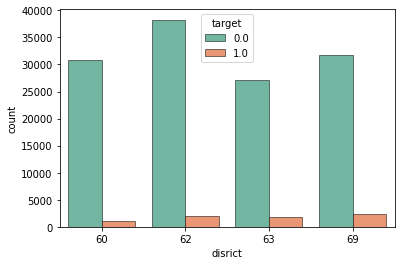

In [110]:
sns.countplot(x='disrict',data=train_client,hue= 'target', palette='Set2', linewidth=0.5, edgecolor='black');

In [111]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135493 entries, 0 to 135492
Data columns (total 56 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   disrict                    135493 non-null  int64  
 1   client_catg                135493 non-null  int64  
 2   region                     135493 non-null  int64  
 3   target                     135493 non-null  float64
 4   1transactions_count        135493 non-null  int64  
 5   consommation_level_1_sum   135493 non-null  int64  
 6   consommation_level_1_max   135493 non-null  int64  
 7   consommation_level_1_min   135493 non-null  int64  
 8   consommation_level_1_mean  135493 non-null  float64
 9   consommation_level_2_sum   135493 non-null  int64  
 10  consommation_level_2_max   135493 non-null  int64  
 11  consommation_level_2_min   135493 non-null  int64  
 12  consommation_level_2_mean  135493 non-null  float64
 13  consommation_level_3_sum   13

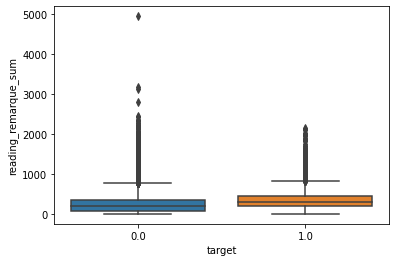

In [112]:

sns.boxplot(x ='target', y ='reading_remarque_sum', data = train)


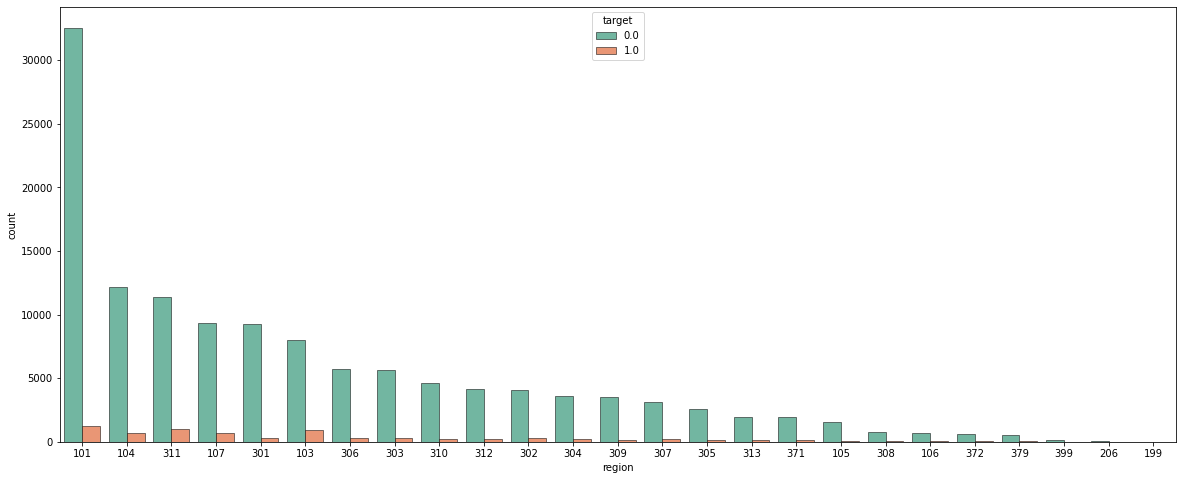

In [113]:
plt.subplots(figsize=(20,8))# Sample figsize in inches
sns.countplot(x='region',data=train_client,hue= 'target', palette='Set2', linewidth=0.5, edgecolor='black',order = train_client['region'].value_counts().index);

### 5) Univariate Analysis

<b> Is the data balanced? </b>

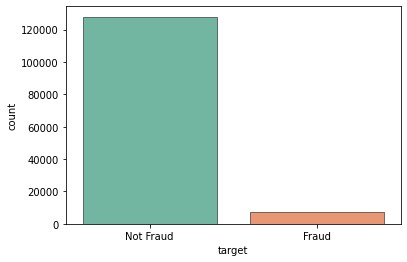

In [114]:
plot= sns.countplot(x='target',data=train, palette='Set2', linewidth=0.5, edgecolor='black');
plot.set_xticklabels(['Not Fraud', 'Fraud']);

In [128]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135493 entries, 0 to 135492
Data columns (total 56 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   disrict                    135493 non-null  int64  
 1   client_catg                135493 non-null  int64  
 2   region                     135493 non-null  int64  
 3   target                     135493 non-null  float64
 4   1transactions_count        135493 non-null  int64  
 5   consommation_level_1_sum   135493 non-null  int64  
 6   consommation_level_1_max   135493 non-null  int64  
 7   consommation_level_1_min   135493 non-null  int64  
 8   consommation_level_1_mean  135493 non-null  float64
 9   consommation_level_2_sum   135493 non-null  int64  
 10  consommation_level_2_max   135493 non-null  int64  
 11  consommation_level_2_min   135493 non-null  int64  
 12  consommation_level_2_mean  135493 non-null  float64
 13  consommation_level_3_sum   13

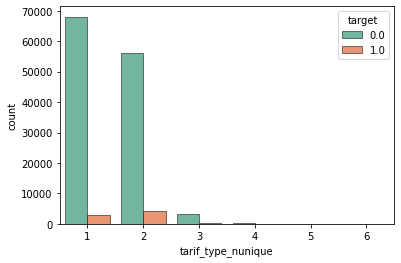

In [115]:
sns.countplot(x='tarif_type_nunique',data=train, hue='target', palette='Set2', linewidth=0.5, edgecolor='black');

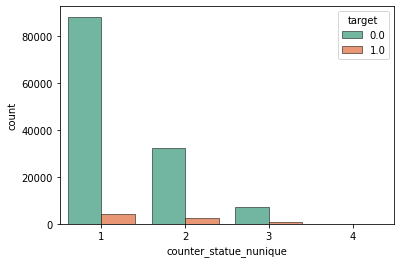

In [116]:
sns.countplot(x='counter_statue_nunique',data=train, hue='target', palette='Set2', linewidth=0.5, edgecolor='black');

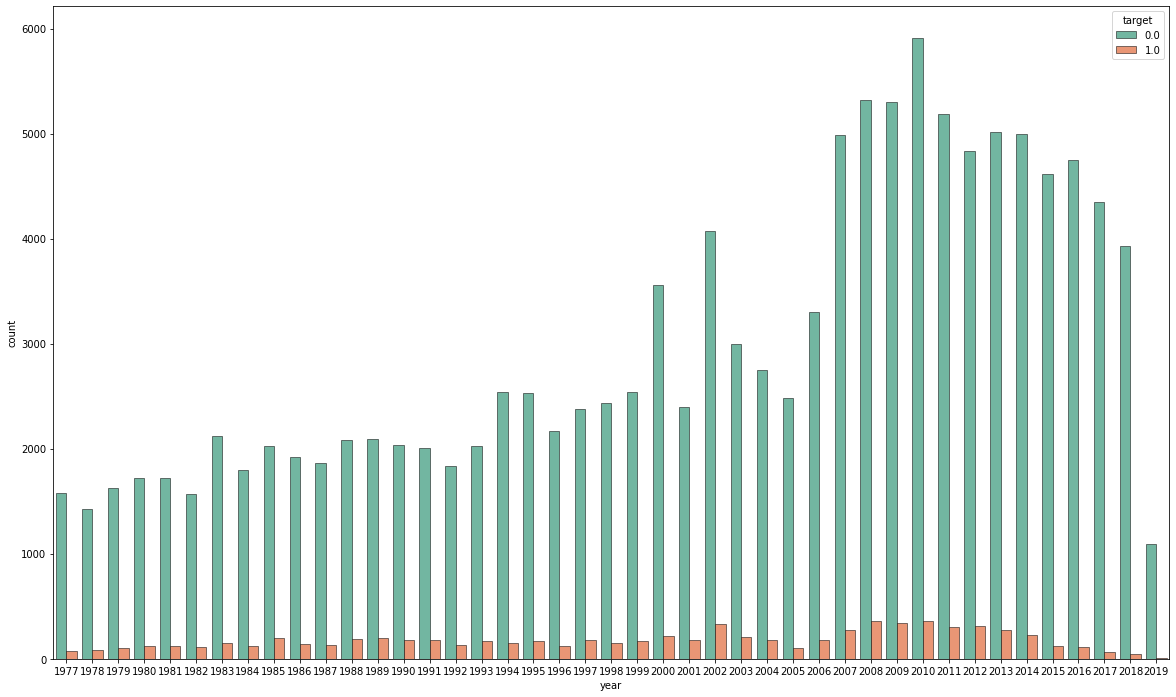

In [118]:
plt.figure(figsize=(20,12))
sns.countplot(x='year',data=train, hue='target', palette='Set2', linewidth=0.5, edgecolor='black');

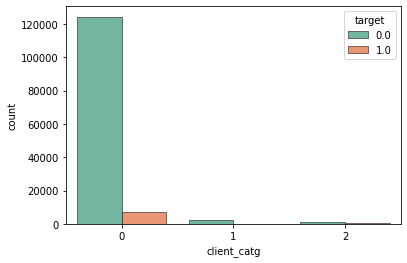

In [119]:
sns.countplot(x='client_catg',data=train, hue='target', palette='Set2', linewidth=0.5, edgecolor='black');

In [121]:
train_new=train.copy(deep=True)
train_new['consum_total']= train['consommation_level_1_sum']+train['consommation_level_2_sum']+train['consommation_level_3_sum']+train['consommation_level_4_sum']+0.01

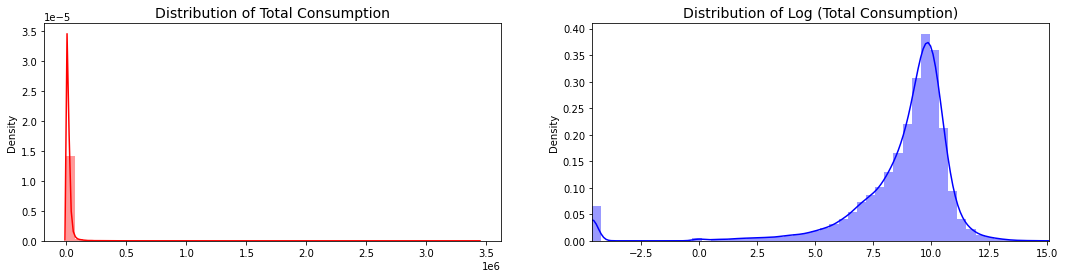

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))
time_val = train_new['consum_total'].values
sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Total Consumption', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of Log (Total Consumption)', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])
plt.show()

<b> Are the STEG agent able to recognize the fraud case by its remark?</b> 

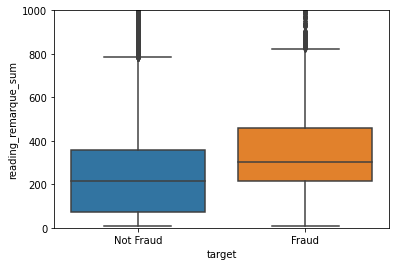

In [138]:
plot= sns.boxplot( x="target", y="reading_remarque_sum", data=train);
plot.set_xticklabels(['Not Fraud', 'Fraud']);
plot.set(ylim=(0, 1000));

<b>Does the fraud clients consume more than the normal people? </b> 

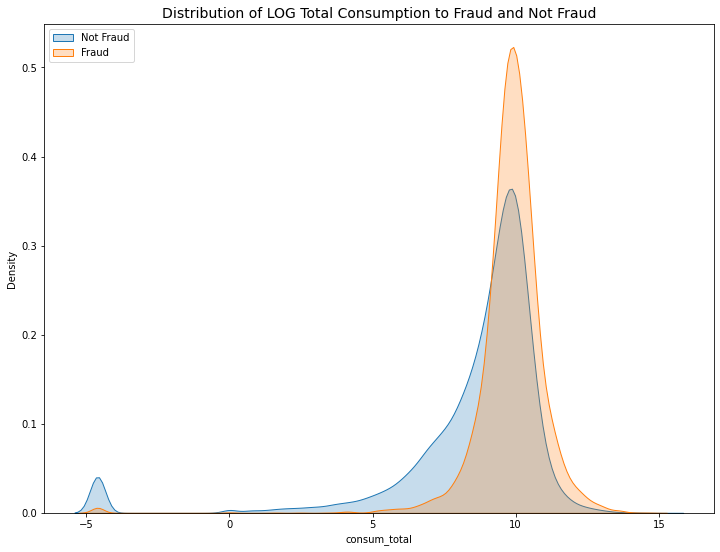

In [167]:
# Sort the dataframe by target
plt.figure(figsize=(12,9))
ax= sns.kdeplot(np.log(train_new[train_new['target']==0]['consum_total']), fill=True);
ax= sns.kdeplot(np.log(train_new[train_new['target']==1]['consum_total']), fill=True);
ax.set_title('Distribution of LOG Total Consumption to Fraud and Not Fraud', fontsize=14);
plt.legend(loc='upper left', labels=['Not Fraud','Fraud']);

In [ ]:
sns.displot(data=train_new, x=np.log(train_new[train_new['target']==0]['consum_total']), kind='kde', fill=True,  height=5, aspect=1.5);
sns.displot(data=train_new, x=np.log(train_new[train_new['target']==1]['consum_total']), kind='kde', fill=True, height=5, aspect=1.5);
plt.show()

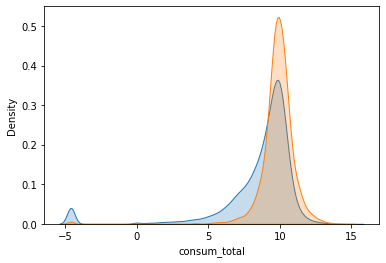

In [148]:
train_new[train_new['target']==0]['consum_total']

0         12704.01
1         20629.01
2         15057.01
3            24.01
4         12917.01
            ...   
135488      139.01
135489     7651.01
135490     9831.01
135491      741.01
135492     1378.01
Name: consum_total, Length: 127927, dtype: float64

### 2) Feature Selection and Importance

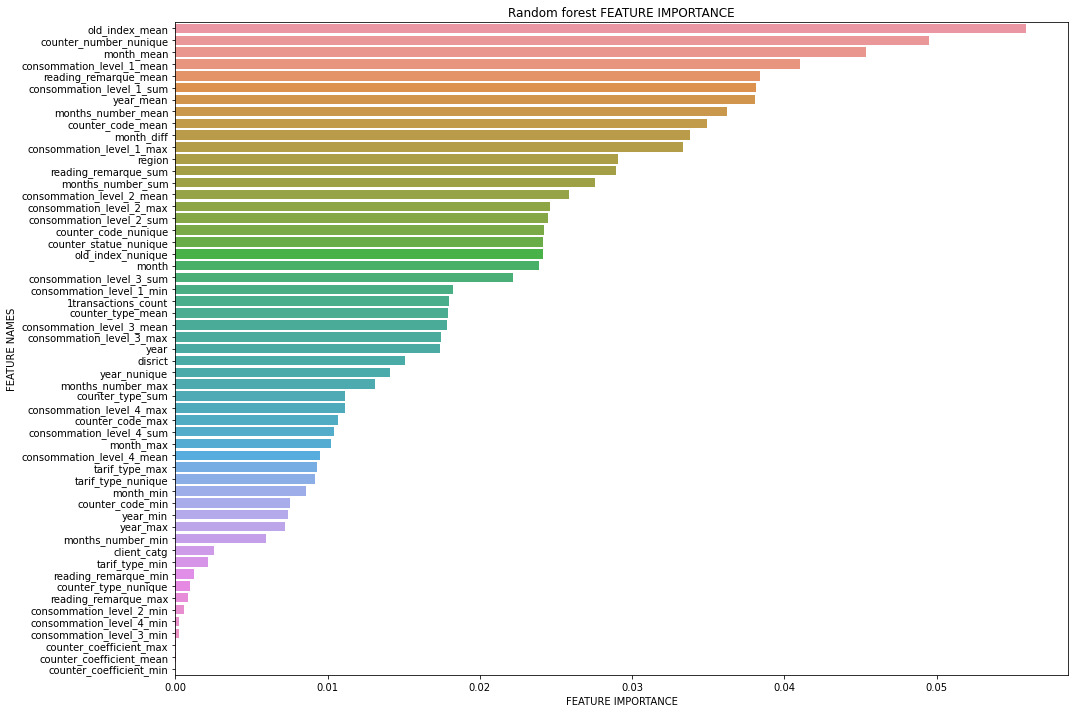

In [275]:
#Create arrays from feature importance and feature names
feature_importance = np.array(rf_clf.feature_importances_)
feature_names = np.array(train.columns)

#Create a DataFrame using a Dictionary
data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
plt.figure(figsize=(16,12))
#Plot Searborn bar chart
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names']);
#Add chart labels
plt.title( 'Random forest FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES');

## C- Training/Testing Models

In [260]:
target=train['target']
train.drop('target',axis=1,inplace=True)

### XGBoost clf

In [261]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=2019,
)
%time xgb_clf.fit(train, target)

CPU times: user 6min 57s, sys: 723 ms, total: 6min 57s
Wall time: 7min 4s


XGBClassifier(colsample_bytree=0.9, learning_rate=0.05, max_depth=9,
              n_estimators=500, random_state=2019, subsample=0.9)

In [262]:
xgb_pred=xgb_clf.predict_proba(test)
xgb_pred

array([[0.9808364 , 0.01916362],
       [0.8824636 , 0.11753645],
       [0.9854784 , 0.01452159],
       ...,
       [0.38441002, 0.61559   ],
       [0.99890953, 0.00109045],
       [0.92984885, 0.07015117]], dtype=float32)

### LGBM clf

In [263]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9
          }
lgb_clf= LGBMClassifier(**params)
%time lgb_clf.fit(train, target)

CPU times: user 16.2 s, sys: 185 ms, total: 16.3 s
Wall time: 19.7 s


LGBMClassifier(bagging_seed=11, colsample_bytree=0.9, learning_rate=0.03,
               max_depth=13, metric='auc', min_child_samples=79, num_leaves=256,
               objective='binary', reg_alpha=0.3, reg_lambda=0.3, subsample=0.9,
               subsample_freq=3, verbosity=-1)

In [264]:
lgb_pred= lgb_clf.predict_proba(test)
lgb_pred.shape

(58069, 2)

### ExtraTree clf

In [ ]:
model = ExtraTreeClassifier( n_jobs=4, min_samples_split=25,
                            min_samples_leaf=35, max_features=150)
                            
gsc = GridSearchCV(
    estimator=model,
    param_grid={
        #'n_estimators': range(50,126,25),
        'max_features': range(50,401,50),
        'criterion': ['gini','entropy'],
    },
    scoring='accuracy',
    cv=5
)

grid_result = gsc.fit(train, target)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.944779 using {'criterion': 'gini', 'max_features': 50}


In [ ]:
extratree_clf = ExtraTreeClassifier( criterion= 'gini', max_features=50)
%time extratree_clf.fit(train, target)

CPU times: user 1.42 s, sys: 8.98 ms, total: 1.43 s
Wall time: 1.48 s


ExtraTreeClassifier(max_features=50)

In [ ]:
extratree_pred=extratree_clf.predict_proba(test)
extratree_pred.shape

(58069, 2)

### RF

In [265]:
rf_clf = RandomForestClassifier(criterion= 'gini', max_features=30)
%time rf_clf.fit(train, target)

CPU times: user 3min 6s, sys: 354 ms, total: 3min 7s
Wall time: 3min 6s


RandomForestClassifier(max_features=30)

In [266]:
rf_pred=rf_clf.predict_proba(test)
rf_pred.shape

(58069, 2)

In [267]:
rf_pred

array([[1.  , 0.  ],
       [0.87, 0.13],
       [1.  , 0.  ],
       ...,
       [0.45, 0.55],
       [1.  , 0.  ],
       [0.97, 0.03]])

### KNN

In [ ]:
knn_clf = KNeighborsClassifier()
%time knn_clf.fit(train, target)

CPU times: user 49.1 ms, sys: 6.03 ms, total: 55.2 ms
Wall time: 67.7 ms


KNeighborsClassifier()

In [ ]:
knn_pred=knn_clf.predict_proba(test)
knn_pred.shape

KeyboardInterrupt: ignored

In [ ]:
knn_pred

array([[1. , 0. ],
       [0.8, 0.2],
       [1. , 0. ],
       ...,
       [0.6, 0.4],
       [1. , 0. ],
       [0.8, 0.2]])

### DecisionTreeClassifier

In [ ]:
dtree_clf = DecisionTreeClassifier()
%time dtree_clf.fit(train, target)

CPU times: user 4.62 s, sys: 21.8 ms, total: 4.64 s
Wall time: 4.63 s


DecisionTreeClassifier()

In [ ]:
dtree_pred=dtree_clf.predict_proba(test)
dtree_pred.shape

(58069, 2)

In [ ]:
dtree_pred

NameError: ignored

### SVC

In [ ]:

svc_clf = make_pipeline(StandardScaler(), SVC(gamma='auto')) #Faster computation
%time svc_clf.fit(train, target)

In [ ]:
svc_pred=svc_clf.predict_proba(test)
svc_pred.shape

In [ ]:
svc_pred

### AdaBoostClassifier

In [ ]:
ada_clf = AdaBoostClassifier() #Faster computation
%time ada_clf.fit(train, target)

CPU times: user 17.2 s, sys: 83 ms, total: 17.3 s
Wall time: 17.2 s


AdaBoostClassifier()

In [ ]:
ada_pred=ada_clf.predict_proba(test)
ada_pred.shape

(58069, 2)

In [ ]:
ada_pred

array([[0.5180699 , 0.4819301 ],
       [0.51241244, 0.48758756],
       [0.51399944, 0.48600056],
       ...,
       [0.50828858, 0.49171142],
       [0.52773843, 0.47226157],
       [0.51018147, 0.48981853]])

### Ensemble Learning Result #1

In [ ]:
preds=pred[:,1]*0.4+0.3*lgbm_pred[:,1]+ 0.1*rf_pred[:,1]+ 0.2*ada_pred[:,1]

In [ ]:
preds = pd.DataFrame(preds)

In [ ]:
preds.head()

,0
0,0.116094
1,0.192291
2,0.109399
3,0.097486
4,0.161170


### Stacking and Blending Result

In [ ]:
stack_gen = StackingCVClassifier(classifiers=(ada_clf, rf_clf, model),
                                 use_probas=True,
                                 meta_classifier=clf)
%time stack_gen.fit(np.array(train), np.array(target))

CPU times: user 10min 16s, sys: 2.23 s, total: 10min 18s
Wall time: 10min 17s


StackingCVClassifier(classifiers=(AdaBoostClassifier(),
                                  RandomForestClassifier(max_features=30),
                                  LGBMClassifier(num_iteration=500)),
                     meta_classifier=StackingClassifier(estimators=[('rf',
                                                                     RandomForestClassifier(n_estimators=10,
                                                                                            random_state=42)),
                                                                    ('svr',
                                                                     Pipeline(steps=[('standardscaler',
                                                                                      StandardScaler()),
                                                                                     ('linearsvc',
                                                                                      LinearSVC(random_state=42))]))],
 

In [ ]:
stack_gen_pred=stack_gen.predict_proba(test)
stack_gen_pred.shape

(58069, 2)

In [ ]:
stack_gen_pred

array([[0.97425648, 0.02574352],
       [0.92276852, 0.07723148],
       [0.97053287, 0.02946713],
       ...,
       [0.23955546, 0.76044454],
       [0.97790778, 0.02209222],
       [0.96138769, 0.03861231]])

In [ ]:
preds= stack_gen_pred[:,1]
preds = pd.DataFrame(preds)
preds

,0
0,0.025744
1,0.077231
2,0.029467
3,0.021470
4,0.058709
...,...
58064,0.022804
58065,0.029269
58066,0.760445
58067,0.022092


In [ ]:
preds=pred[:,1]*0.2+0.2*lgbm_pred[:,1]+ 0.1*rf_pred[:,1]+ 0.15*ada_pred[:,1]+ 0.35*stack_gen_pred[:,1]
preds = pd.DataFrame(preds)
preds

,0
0,0.087549
1,0.164448
2,0.090294
3,0.079995
4,0.144206
...,...
58064,0.080634
58065,0.095906
58066,0.639512
58067,0.079315


### CatBoost clf

In [268]:
cat_clf = CatBoostClassifier()
cat_clf.fit(train,target)

Learning rate set to 0.083804
0:	learn: 0.5814201	total: 61.2ms	remaining: 1m 1s
1:	learn: 0.4916712	total: 123ms	remaining: 1m 1s
2:	learn: 0.4302083	total: 189ms	remaining: 1m 2s
3:	learn: 0.3759036	total: 253ms	remaining: 1m 3s
4:	learn: 0.3353858	total: 324ms	remaining: 1m 4s
5:	learn: 0.3034741	total: 400ms	remaining: 1m 6s
6:	learn: 0.2795818	total: 457ms	remaining: 1m 4s
7:	learn: 0.2596122	total: 533ms	remaining: 1m 6s
8:	learn: 0.2454105	total: 593ms	remaining: 1m 5s
9:	learn: 0.2325621	total: 664ms	remaining: 1m 5s
10:	learn: 0.2232997	total: 720ms	remaining: 1m 4s
11:	learn: 0.2168922	total: 777ms	remaining: 1m 4s
12:	learn: 0.2084947	total: 845ms	remaining: 1m 4s
13:	learn: 0.2035749	total: 914ms	remaining: 1m 4s
14:	learn: 0.1991606	total: 979ms	remaining: 1m 4s
15:	learn: 0.1941715	total: 1.06s	remaining: 1m 5s
16:	learn: 0.1919668	total: 1.11s	remaining: 1m 4s
17:	learn: 0.1885135	total: 1.2s	remaining: 1m 5s
18:	learn: 0.1860131	total: 1.26s	remaining: 1m 5s
19:	learn: 

In [269]:
cat_pred= cat_clf.predict_proba(test)
cat_pred

array([[0.98008148, 0.01991852],
       [0.8742489 , 0.1257511 ],
       [0.97954889, 0.02045111],
       ...,
       [0.34640912, 0.65359088],
       [0.99680402, 0.00319598],
       [0.92828433, 0.07171567]])

### Ensemble Learning Result #2

In [270]:
preds=xgb_pred[:,1]*0.3+ 0.3*cat_pred[:,1]+0.4*lgb_pred[:,1]
preds = pd.DataFrame(preds)
preds

,0
0,0.020736
1,0.132941
2,0.017420
3,0.006778
4,0.111305
...,...
58064,0.001940
58065,0.026575
58066,0.599380
58067,0.005626


### Submission

In [271]:
submission = pd.DataFrame({
        "client_id": sub["client_id"],
        "target": preds[0]
    })
submission.to_csv('Submission65.csv', index=False)



In [ ]:
#@title Default title text
submission.head(58071)

,client_id,target
0,test_Client_0,0.020545
1,test_Client_1,0.101361
2,test_Client_10,0.011667
3,test_Client_100,0.004791
4,test_Client_1000,0.096399
...,...,...
58064,test_Client_9995,0.001496
58065,test_Client_9996,0.030364
58066,test_Client_9997,0.600000
58067,test_Client_9998,0.005288


In [ ]:
# pred[:,1]*0.3+0.7*lgbm_pred[:,1]
# Best: pred[:,1]*0.4+0.5*lgbm_pred[:,1]+ 0.1*rf_pred[:,1]
# pred[:,1]*0.4+0.4*lgbm_pred[:,1]+ 0.1*rf_pred[:,1]+0.1*knn_pred[:,1] => Bad sub22
# preds=pred[:,1]*0.35+0.35*lgbm_pred[:,1]+ 0.1*rf_pred[:,1]+ 0.2*ada_pred[:,1] => Best (4th)
#preds=pred[:,1]*0.4+0.3*lgbm_pred[:,1]+ 0.1*rf_pred[:,1]+ 0.2*ada_pred[:,1] => Best (4th)
#  Submission42.csv => 8846 => nice lgbm*0.5+ 0.4 xgb+0.1 ada
# Submission46 => 0.5*xgb[0]+0.5*x[0]
# Submission47=> 0.6*xgb[0]+0.4*x[0]
# 48 =. pred[:,1]*0.3+ + rf_pred[:,1]*0.1 + 0.5*x => 0.88431
# 49 => pred[:,1]*0.3+ + rf_pred[:,1]*0.2 + 0.5*x  => 0.8829
# 50 => pred[:,1]*0.3+ + ada_pred[:,1]*0.3+0.4*x => 0.884340
# 52=> pred[:,1]*0.3+ + ada_pred[:,1]*0.1+0.2*cat_pred[:,1] => 0.8851
# 54=> pred[:,1]*0.3+ 0.3*cat_pred[:,1]+0.4x =>  0.8852
# 56 => pred[:,1]*0.3+ 0.3*cat_pred[:,1]+0.1*ada_pred[:,1]+0.3x => 0.8851